# **ROBOT TRADING**

#1. Configuración del ambiente

In [92]:
# Revisión de versiones de las librerías
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.11
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.22.4
------
Name: matplotlib
Version: 3.7.1


In [93]:
# Importación de las librerías empleadas
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import yfinance as yf

from bs4 import BeautifulSoup as bs
import requests
from urllib.request import Request, urlopen
from urllib.error import URLError, HTTPError

from IPython.display import clear_output
import time
import datetime as dt

In [94]:
# Definir variables globales
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

#2. Obtención de Datos

En este apartado se obtiene la información del precio histórico del Bitcoin, empleando como fuente de datos yahoo finance

##2.1 Precios históricos del Bitcoin

In [95]:
"""Función que extrae los datos históricos del bitcoin de los últimos 7 días, en intervalos de 5 minutos.
   Los datos extraidos son almacenados en el dataframe df_bitcoin"""
def importar_base_bitcoin():
  global df_bitcoin
  msft = yf.Ticker("BTC-USD")
  df_bitcoin=msft.history(period="7d", interval="5m")
  return df_bitcoin

In [96]:
# Se llama la función y se valida el contenido del dataframe df_bitcoin
importar_base_bitcoin()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-05-26 00:00:00+00:00,26474.181641,26486.089844,26474.181641,26481.548828,0,0.0,0.0
2023-05-26 00:05:00+00:00,26481.531250,26481.531250,26460.160156,26460.160156,0,0.0,0.0
2023-05-26 00:10:00+00:00,26450.755859,26457.359375,26444.072266,26457.144531,0,0.0,0.0
2023-05-26 00:15:00+00:00,26455.166016,26466.228516,26455.166016,26466.228516,4686848,0.0,0.0
2023-05-26 00:20:00+00:00,26464.923828,26498.097656,26464.923828,26498.097656,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-01 02:00:00+00:00,27092.111328,27096.082031,27076.017578,27076.017578,1093632,0.0,0.0
2023-06-01 02:05:00+00:00,27070.572266,27075.585938,27064.576172,27075.585938,0,0.0,0.0
2023-06-01 02:10:00+00:00,27076.285156,27090.652344,27064.804688,27064.804688,0,0.0,0.0


##2.2 Indicadores de Tendencia

La información para los indicadores de tendencia se extraen de la página https://coinmarketcap.com/. 

Como no podemos garantizar que el Bitcoin sea el que aparezca siempre de primeras en la tabla, extraemos todos los registros y posteriormente filtramos los datos para mantener solamente los valores realacionados con el bitcoin

In [97]:
#En esta función se obtienen los valores del precio actual y tendencia del precio del bitcoin en la ultima hora.

def extraer_tendencias():
  global precio_actual, tendencia
  """Se establece el user-agent que se esta usando para visualizar la pagina acorde con el navegador que se esta empleando.
     Se usa la página: https://www.whatismybrowser.com/es/detect/what-is-my-user-agent/"""
  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36'}
  url="https://coinmarketcap.com/"

  name=[]
  price=[]
  trend=[]

  try: 
    response = requests.get(url, headers=headers)
    soup = bs(response.content, features='lxml')

    names = soup.findAll('div',{'class':'sc-aef7b723-0 sc-8497df48-1 iATetF name-area'})
    prices = soup.findAll('div',{'class':'sc-cadad039-0 clgqXO'})
    trends = soup.findAll('span',{'class':['sc-97d6d2ca-0 cYiHal','sc-97d6d2ca-0 bQjSqS']})

    for item in names:
      name.append(item.text.strip())
    
    for item in prices:
      price.append(item.text.replace('$','').replace(',',''))
  
    for item in trends:
      if str(item.contents[0]).find('icon-Caret-up')>0:
        trend.append(1)
      else:
        trend.append(0)
    #Como la pagina muestra 3 indicadores con tendencia, leemos la lista en saltos de 3 para obtener únicamente las tendencias de la columna 1h%
    trend=trend[::3]

    datos = {
       'Price': price,
       'Trend': trend
    }
  
    dataset = pd.DataFrame(datos, index = name)
    dataset = dataset.loc[['Bitcoin1BTC']]
  
    precio_actual = float(dataset.Price)
    tendencia = int(dataset.Trend)

    if tendencia==1:
      tendencia = 'alta'
    else:
      tendencia = 'baja'

  except HTTPError as e:
    print(e.status, e.reason)
    
  except URLError as e:
    print(e.reason)

  return [precio_actual, tendencia]


In [98]:
extraer_tendencias()

[27058.13, 'baja']

#Limpieza de datos

En este apartado se realiza el análisis y tratamiento de los datos. 

**Metadata del DataFrame df_bitcoin**

---

**Datetime**: Es el índice del dataframe, y contiene la fecha y hora del intervalo seleccionado, no puede estar duplicado.

**Open**: Contiene el precio del Bitcoin al inicio del intervalo.

**High**: Contiene el precio más alto del Bitcoin durante el intervalo.

**Low**: Contiene el precio más bajo del Bitcoin durante el intervalo.

**Close**: Contiene el precio del Bitcoin al final del intervalo.

**Volume**: Contiene el total de transacciones hechas durante el intervalo.

In [99]:
def limpieza_datos():
  global media_bitcoin

  #Se crea una copia de la base df_bitcoin para realizar la limpieza de datos sin afectar la base original
  df_bitcoin_limpio = df_bitcoin.copy()

  #Se espera que exista un único registro por fecha y hora. Sin embargo, si existe más de uno se eliminan de la base, teniendo en cuenta
  #que no se puede determinar cual de los registros es correcto
  df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated()]

  #Buscamos y tratamos los valores nulos en la columna Close, llenando los nulos con el valor medio de cierre del día
  df_bitcoin_limpio['Date'] = df_bitcoin_limpio.index.date 
  df_means = df_bitcoin_limpio.reset_index()[['Date','Close']]
  df_means = df_means.groupby('Date').mean()
  df_means = df_means.reset_index()
  df_bitcoin_limpio = df_bitcoin_limpio.merge(df_means, how='inner', on = 'Date')
  df_bitcoin_limpio['Close'] = df_bitcoin_limpio['Close_x'].fillna(df_bitcoin_limpio['Close_y'])
  df_bitcoin_limpio.drop(['Close_x','Close_y','Date'], axis = 1, inplace = True)

  #Los registros de la base que tengan un Volume de transacción = 0, se eliminan
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio.Volume>0]

  #Identificar y eliminar los outliers en el precio del Bitcoin, columna Close, utiliza un gráfico de boxplot para identificarlos.
  df_bitcoin_limpio.boxplot('Close')
  valores = df_bitcoin_limpio['Close']
  Q1 = valores.quantile(.25)
  Q3 = valores.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ

  #Filtra o selecciona únicamente los registros cuyo precio(Close) se encuentren entre el 1er cuartil(Q1) y el 3er cuartil(Q3) del boxplot
  seleccion = ((valores >= Q1) & (valores <= Q3))
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

  #calcula el precio promedio(Close) de esta selección y guárdala en la variable media_bitcoin.
  media_bitcoin = df_bitcoin_limpio['Close'].mean()

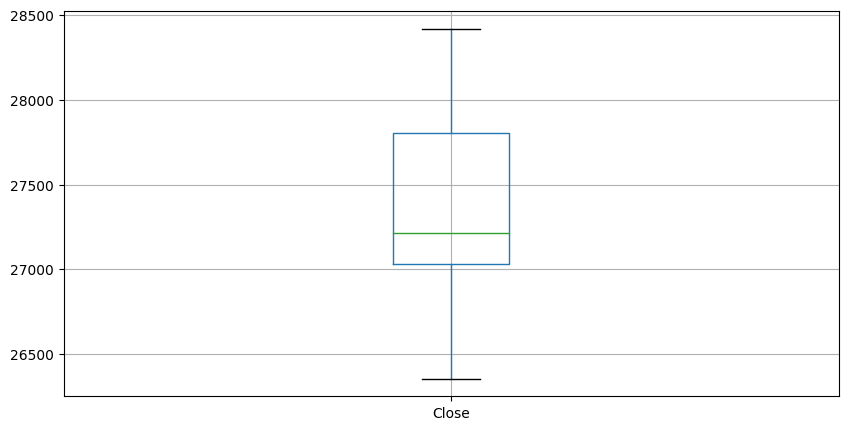

In [100]:
limpieza_datos()

In [101]:
#Función que determina a traves de un algoritmo básico si se debe vender o comparar 
def tomar_decisiones():
  global algoritmo_decision

  if ((precio_actual >= media_bitcoin) & (tendencia == 'baja')):
    algoritmo_decision = 'Vender'
  elif ((precio_actual < media_bitcoin) & (tendencia == 'alta')):
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = '--'

  return algoritmo_decision, precio_actual, media_bitcoin, tendencia


In [102]:
tomar_decisiones()

('--', 27058.13, 27349.813572303923, 'baja')

In [103]:
def visualizacion():
  df_bitcoin['Promedio'] = media_bitcoin
  plt.rc('figure', figsize=(10,5))
  plt.figure(figsize=(15,6), dpi = 300, layout = 'tight')
  plt.plot(df_bitcoin.index, df_bitcoin.Close)
  plt.plot(df_bitcoin.index, df_bitcoin.Promedio)
  plt.title('Análisis de precios del Bitcoin', fontsize=20, color='#035e73')

  #Se incluye en el gráfico la decisión
  plt.annotate(algoritmo_decision, xy=(0.85, 0.85), xycoords='axes fraction', fontsize=20, color='#f26d07')
  plt.show()

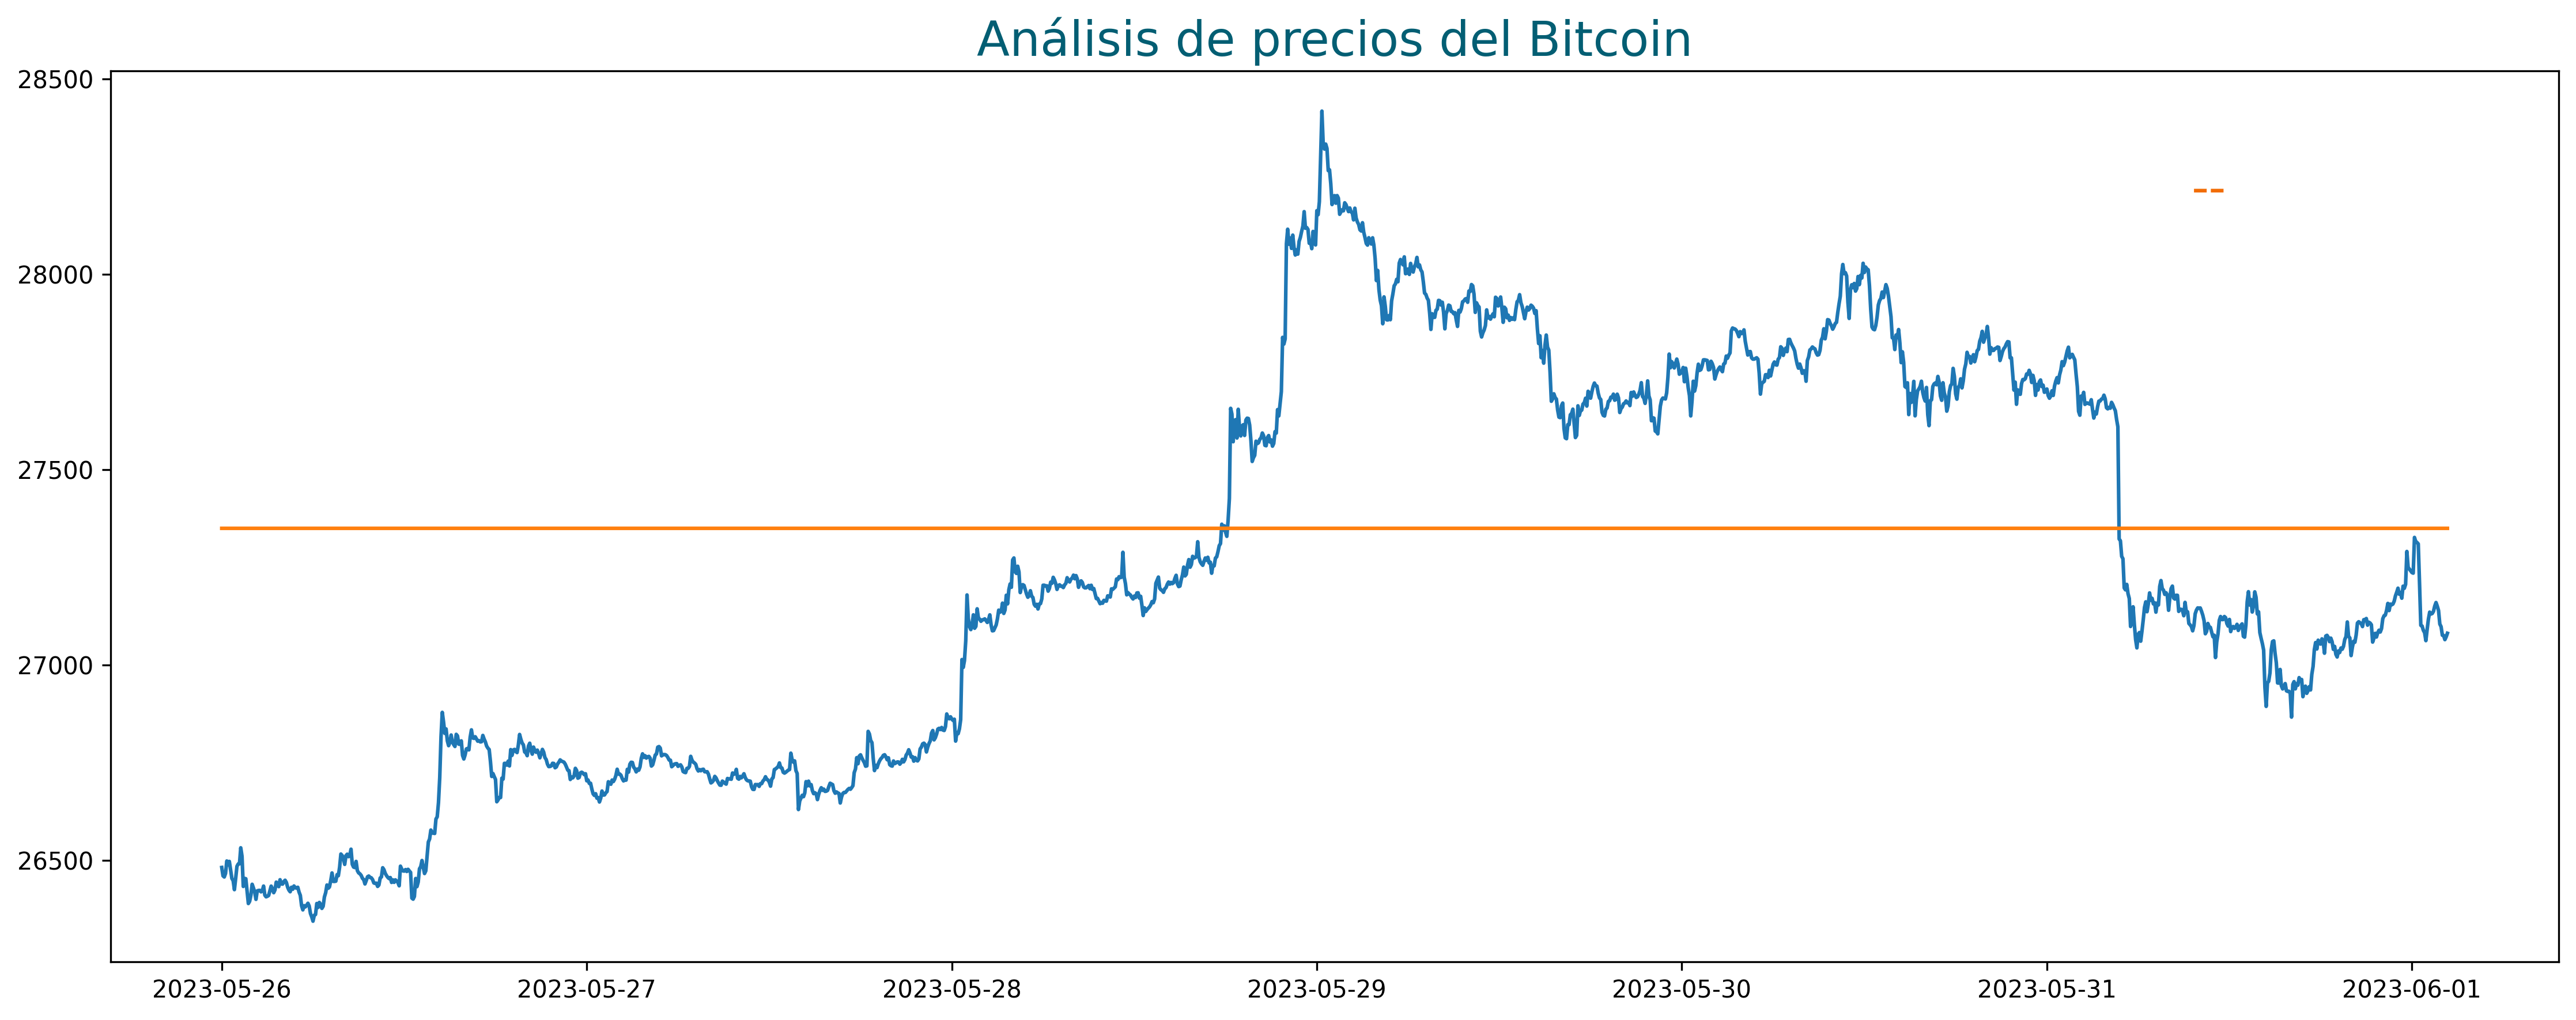

In [104]:
visualizacion()

#Automatización

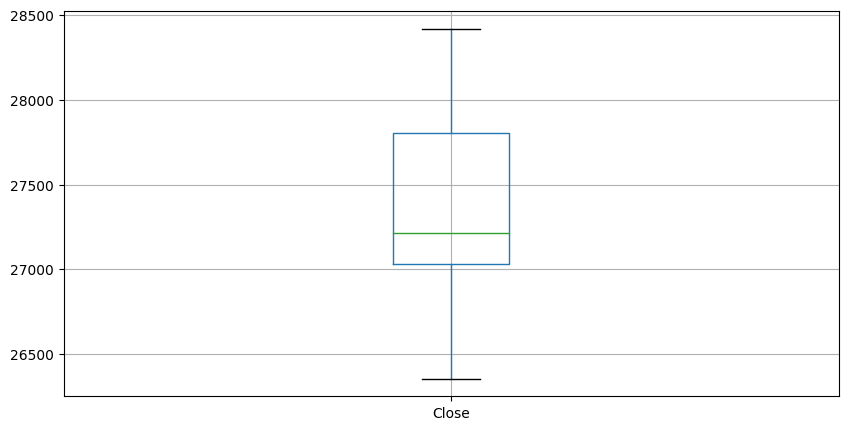

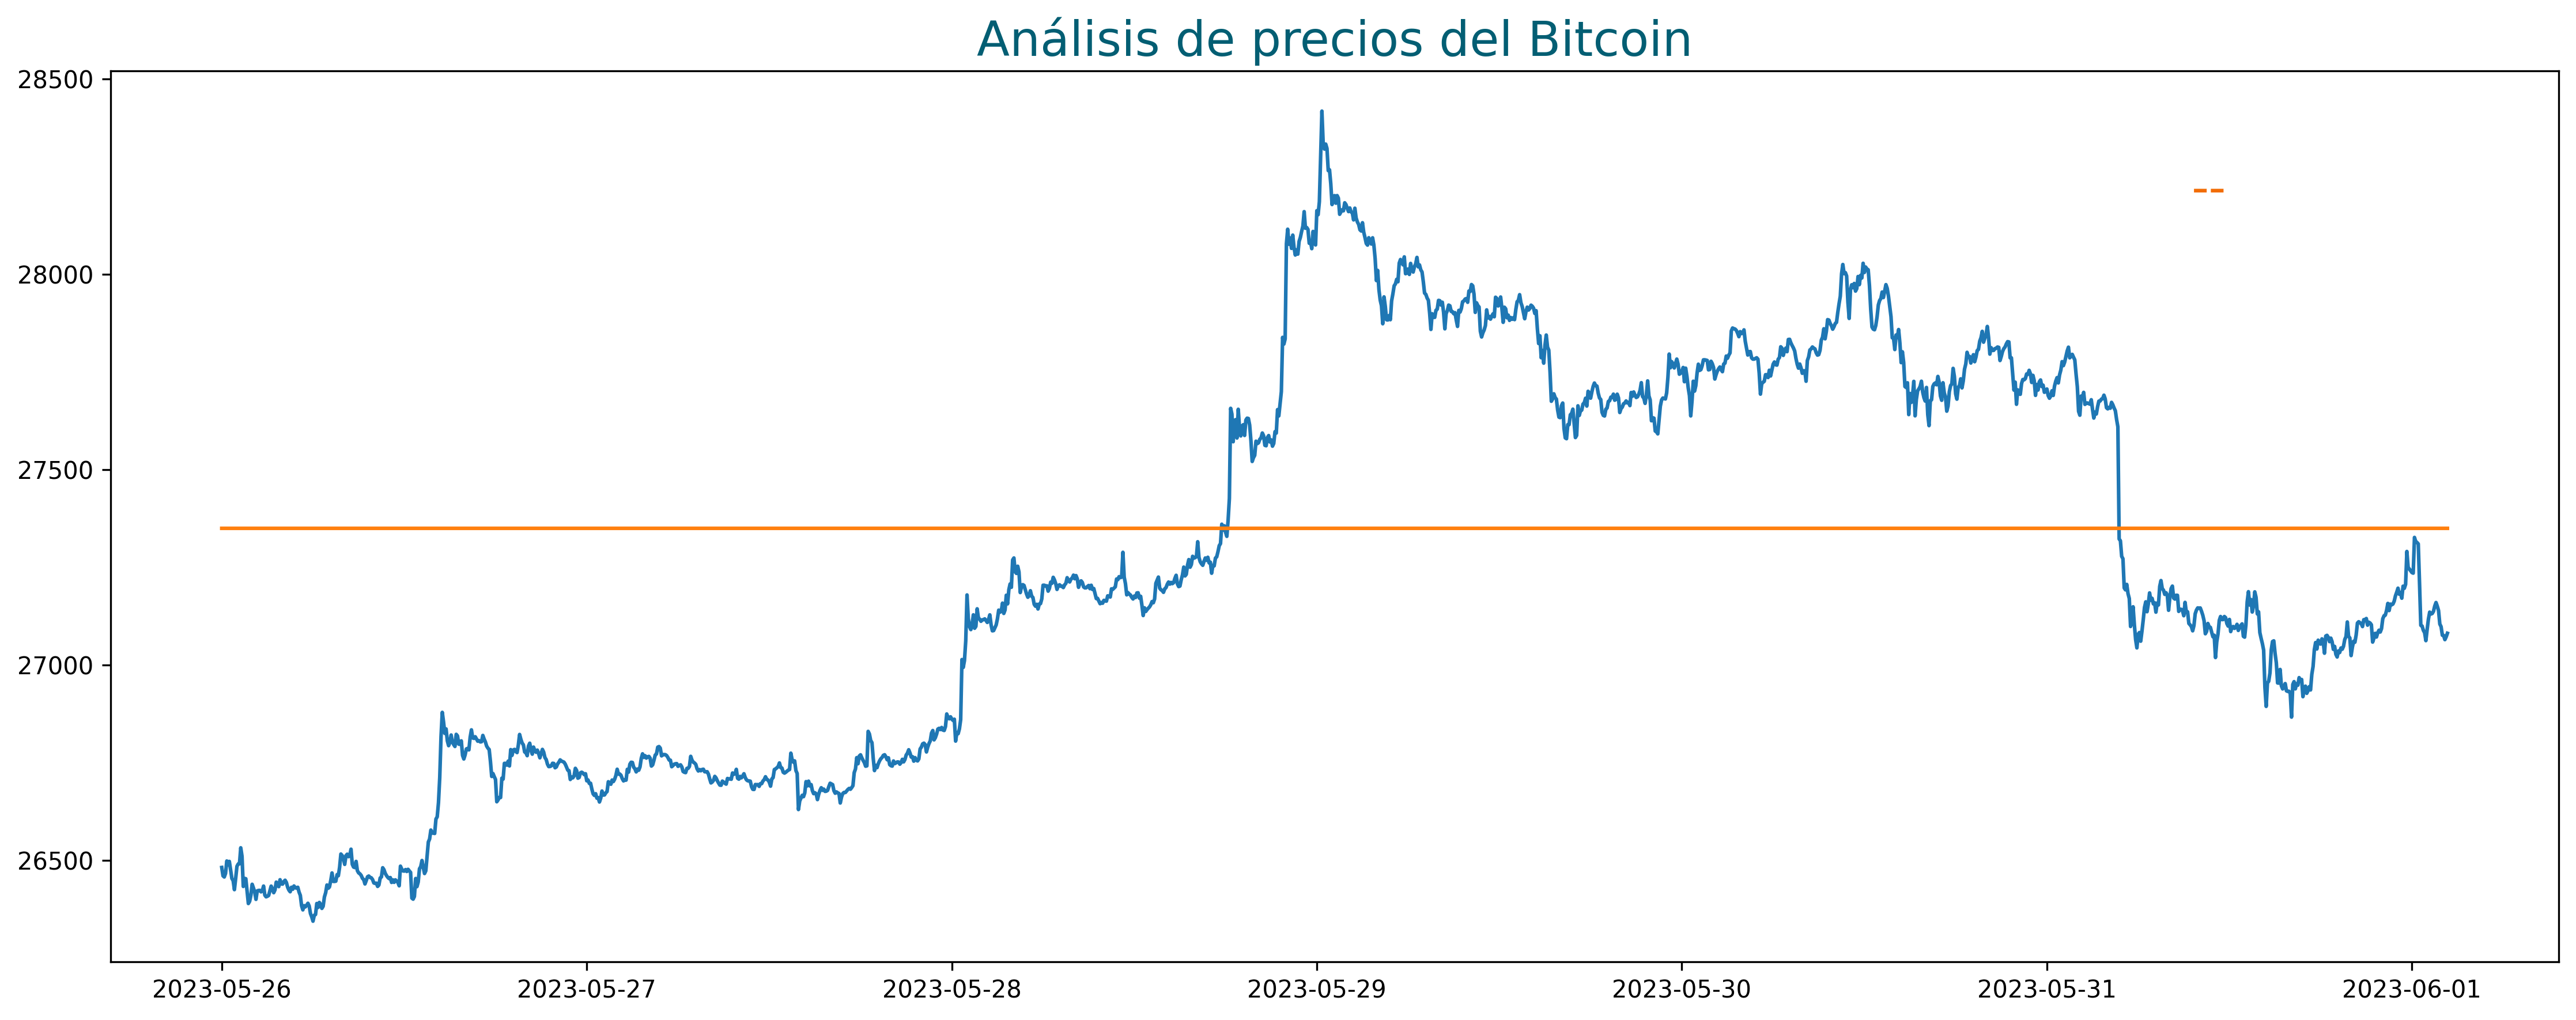

KeyboardInterrupt: ignored

In [105]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)